In [1]:
# Carregant les llibreries necessàries
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import collections as col
import scipy.stats as stats
import statsmodels.api as sm
import scipy.stats
import random as rand
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import LabelEncoder, StandardScaler, scale
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, HuberRegressor, RANSACRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error , r2_score
import warnings
import time
warnings.filterwarnings("ignore")
import pandas as pd
from shapely.geometry import  Point #conda install -c conda-forge shapely
import geopandas as gpd #pip install geopandas
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
import contextily as ctx #pip3 install contextily

In [2]:
# Obrint el dataset
dataset = pd.read_csv('./train.csv')
print(f'Mida de les dades: {dataset.shape}')
dataset.head()

Mida de les dades: (878049, 9)


Dates        Category                      Descript  \
0  2015-05-13 23:53:00        WARRANTS                WARRANT ARREST   
1  2015-05-13 23:53:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
2  2015-05-13 23:33:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
3  2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   
4  2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   

   DayOfWeek PdDistrict      Resolution                    Address  \
0  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST   
1  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST   
2  Wednesday   NORTHERN  ARREST, BOOKED  VANNESS AV / GREENWICH ST   
3  Wednesday   NORTHERN            NONE   1500 Block of LOMBARD ST   
4  Wednesday       PARK            NONE  100 Block of BRODERICK ST   

            X          Y  
0 -122.425892  37.774599  
1 -122.425892  37.774599  
2 -122.424363  37.800414  
3 -122.426995  37.800873  
4 -122.438738  37.771541

In [3]:
ds_copy = dataset.copy()

## ANÁLISIS VARIBALES EXPLICATIVES

In [4]:
# Mirem si hi ha NaNs
print(pd.isnull(ds_copy).values.sum())

0


In [5]:
# Eliminar dades duplicades
ds_copy.drop_duplicates(subset=None,keep="first",inplace=True)
print('Mida original: ',dataset.shape,'Samples',
     '\nNº de dades repetides: ', dataset.duplicated().sum(),
     '\nMida un cop fet el drop: ',ds_copy.shape,'Samples')

Mida original:  (878049, 9) Samples 
Nº de dades repetides:  2323 
Mida un cop fet el drop:  (875726, 9) Samples


In [6]:
# Eliminar datos incoherentes
ds_copy.describe()

X              Y
count  875726.000000  875726.000000
mean     -122.422623      37.771032
std         0.030363       0.457497
min      -122.513642      37.707879
25%      -122.432952      37.752427
50%      -122.416446      37.775421
75%      -122.406959      37.784380
max      -120.500000      90.000000

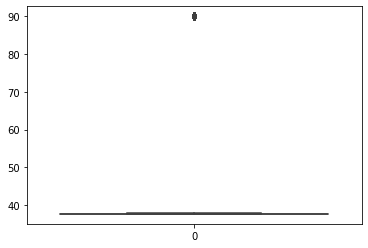

In [7]:
# Eliminar datos fuera de San Francisco
sns.boxplot(ds_copy['Y'])
ds_copy = ds_copy[ds_copy['Y'] <= 40]

In [8]:
ds_copy.describe()

X              Y
count  875659.000000  875659.000000
mean     -122.422770      37.767036
std         0.025281       0.024166
min      -122.513642      37.707879
25%      -122.432952      37.752427
50%      -122.416446      37.775421
75%      -122.406959      37.784380
max      -122.364937      37.819975

In [9]:
# Crims simultanis
counts = ds_copy.groupby(['Dates', 'X', 'Y']).size()
counts = pd.DataFrame(counts)
counts = counts.reset_index()
ds_copy = ds_copy.merge(counts, how='right')
ds_copy.rename(columns={0:'NumMultCrimes'}, inplace=True)

In [10]:
ds_copy['Dates'] = pd.to_datetime(ds_copy['Dates'], format='%Y-%m-%d %H:%M:%S')
ds_copy['Year'] = ds_copy['Dates'].dt.year
ds_copy['Hour'] = ds_copy['Dates'].dt.hour

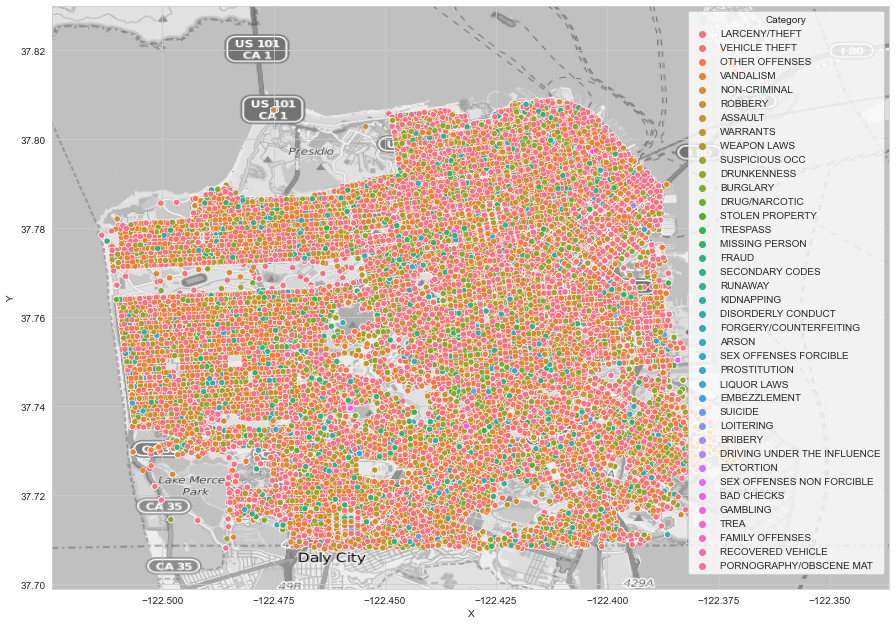

In [25]:
NoneData = ds_copy[ds_copy['Resolution'] == 'NONE']
lon_lat = (-122.5247, -122.3366, 37.699, 37.8299)
mapdata = np.loadtxt("sf_map_copyright_openstreetmap_contributors.txt")

# scatter plot
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(1,1,1)
ax1.imshow(mapdata,extent=lon_lat, cmap=plt.get_cmap('gray'))
sns.scatterplot(x = NoneData['X'], y = NoneData['Y'], hue = NoneData['Category'])
plt.show()

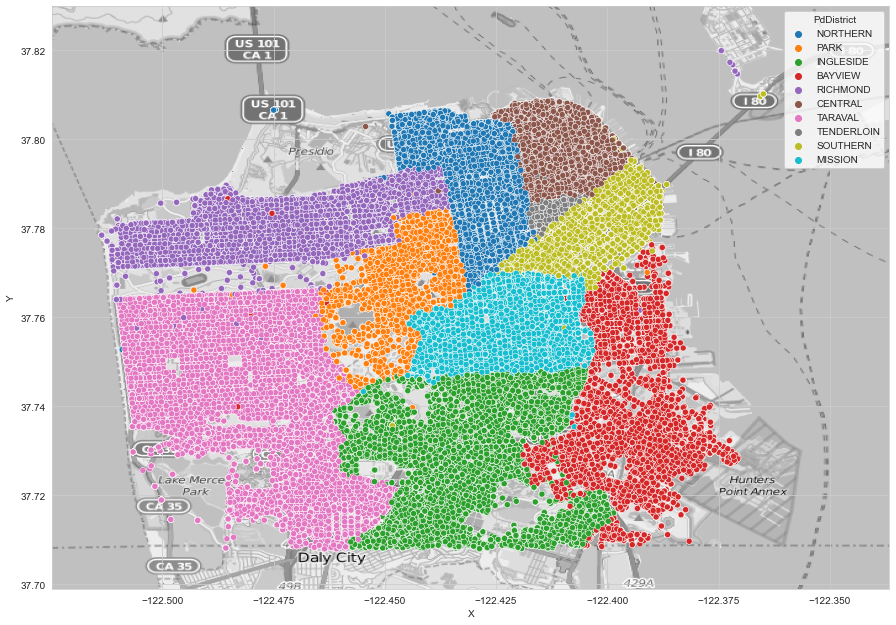

In [26]:
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(1,1,1)
ax1.imshow(mapdata,extent=lon_lat, cmap=plt.get_cmap('gray'))
sns.scatterplot(x = NoneData['X'], y = NoneData['Y'], hue = NoneData['PdDistrict'])
plt.show()

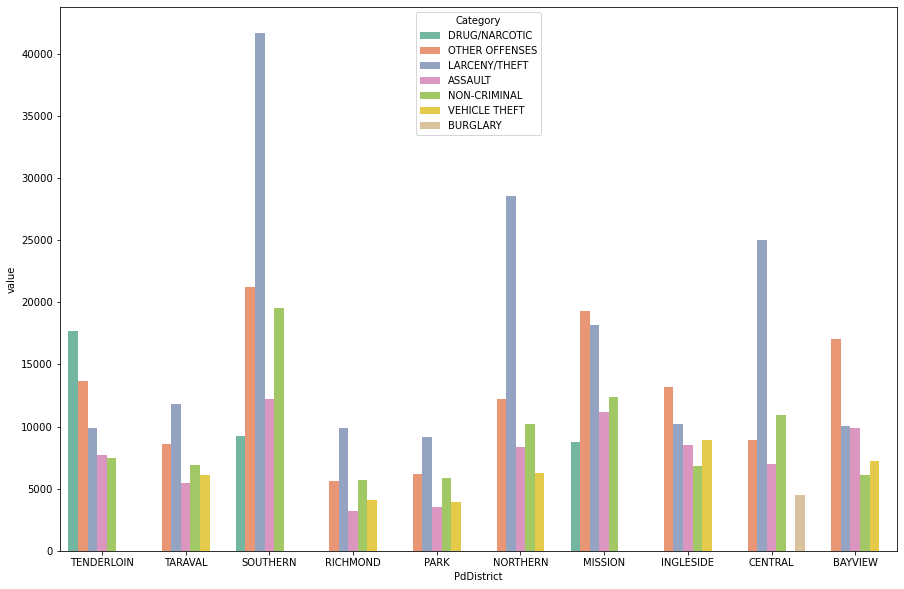

In [18]:
ctDist_Cat = pd.crosstab(ds_copy['PdDistrict'], ds_copy['Category'])
Dist_Cat= ctDist_Cat.stack().reset_index().rename(columns= {0:'value'})
Dist_Cat2 = Dist_Cat.sort_values(by=['PdDistrict','value'], ascending=False).reset_index()
temp = pd.DataFrame()
for d in (Dist_Cat2['PdDistrict'].unique()):
    aux = Dist_Cat2[Dist_Cat2['PdDistrict'] == d]
    temp = pd.concat([temp, aux[0:5]])
fig, bar= plt.subplots(figsize= (15,10))
bar= sns.barplot(x= temp['PdDistrict'], y= temp['value'], hue= temp['Category'], palette='Set2')

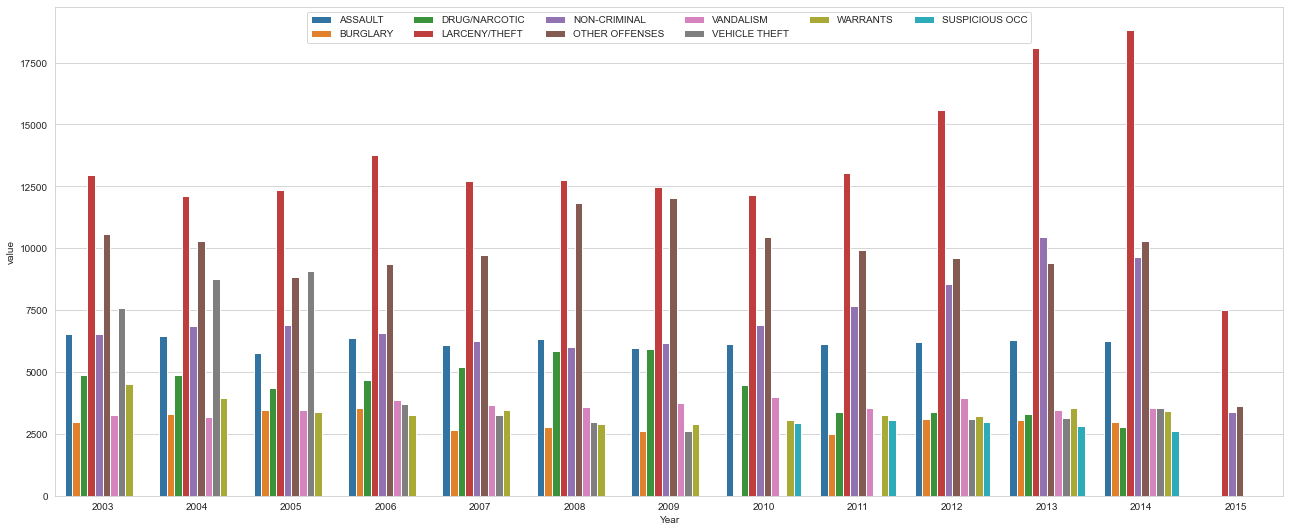

In [19]:
ct_year = pd.crosstab(ds_copy['Year'], ds_copy['Category'])
StackYear= ct_year.stack().reset_index().rename(columns= {0:'value'})
StackYear = StackYear[StackYear['value'] > 2500]
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(22, 9))
ax = sns.barplot(x=StackYear['Year'], y=StackYear['value'],  hue=StackYear['Category'])
ax.legend(loc='best',ncol=6)
plt.show()

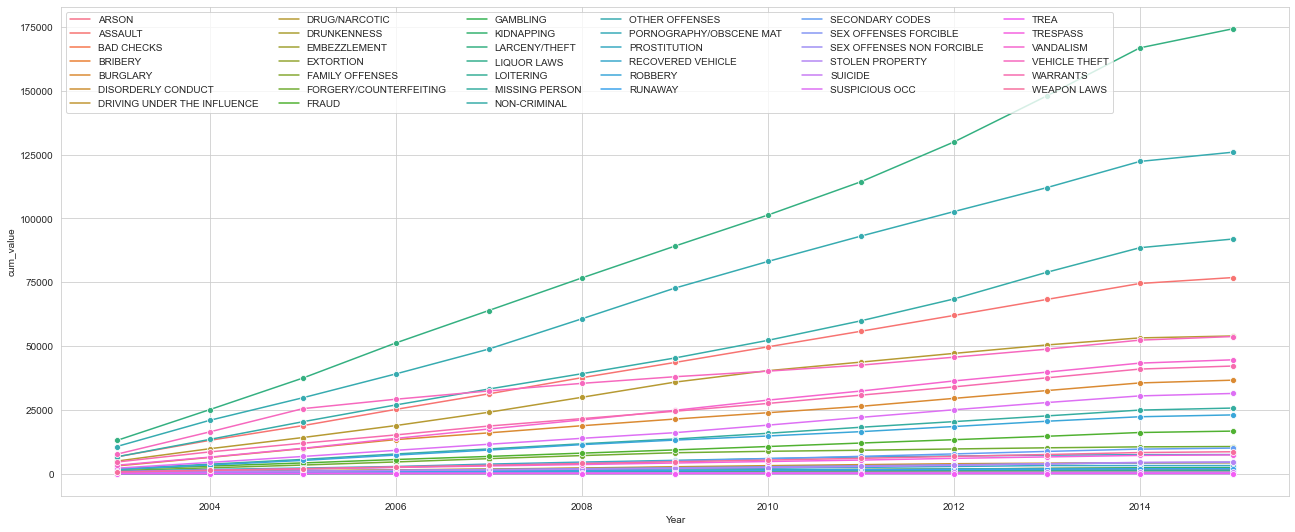

In [20]:
ct_year = pd.crosstab(ds_copy['Year'], ds_copy['Category'])
cm_year = ct_year.cumsum()
StackYear= cm_year.stack().reset_index().rename(columns = {0:'cum_value'})

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(22, 9))
ax = sns.lineplot(x=StackYear['Year'], y=StackYear['cum_value'],  hue=StackYear['Category'], marker="o")
ax.legend(loc='best',ncol=6)
plt.show()

##### ANÁLISIS VARIABLE RESPOSTA

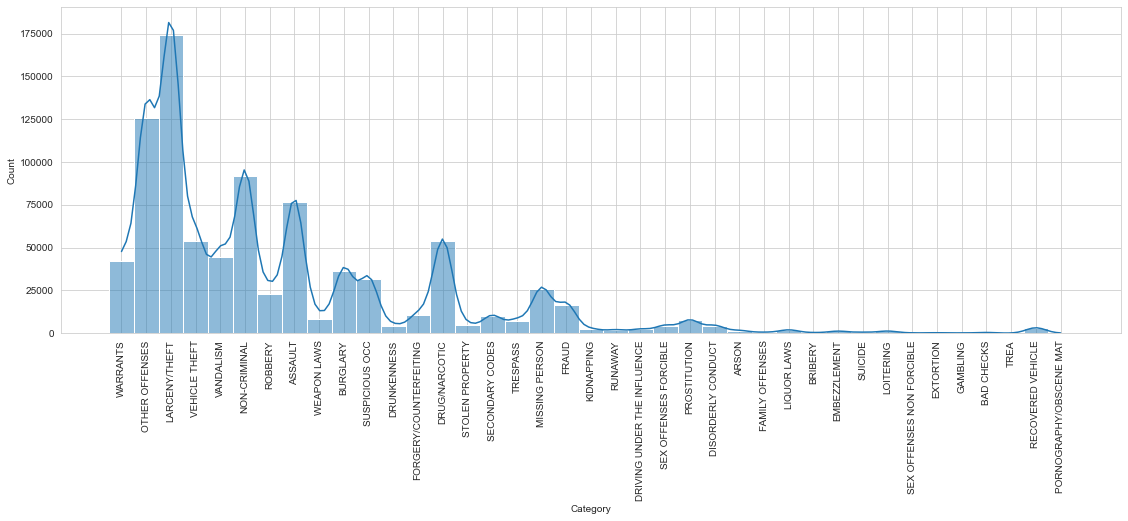

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(19, 6))
sns.histplot(x='Category', data=ds_copy, kde=True, palette='rocket', ax=ax)
ax.tick_params(axis='x', rotation=90)